# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "simon"
ln1 = "zarka-arthus"
fn2 = "julian"
ln2 = "fidelin--durand"

filename = (
    "_".join(map(lambda s: s.strip().lower(), ["lab3", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

lab3_zarka-arthus_simon_and_fidelin--durand_julian.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

C:\Users\simon\AppData\Local\Temp\ipykernel_43920\428856815.py:4: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [10]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        gradient_j = -A[:, j].dot(residuals)
        w[j] += -gradient_j/lips_const[j]
        # update residuals:
        residuals += A[:, j] * (old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.diag(gram)
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient)) 
        old_w_j = w[j] 
        w[j] -= gradient[j]/lips_const[j]
        # update gradient:
        gradient += (w[j] - old_w_j) * gram[:, j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

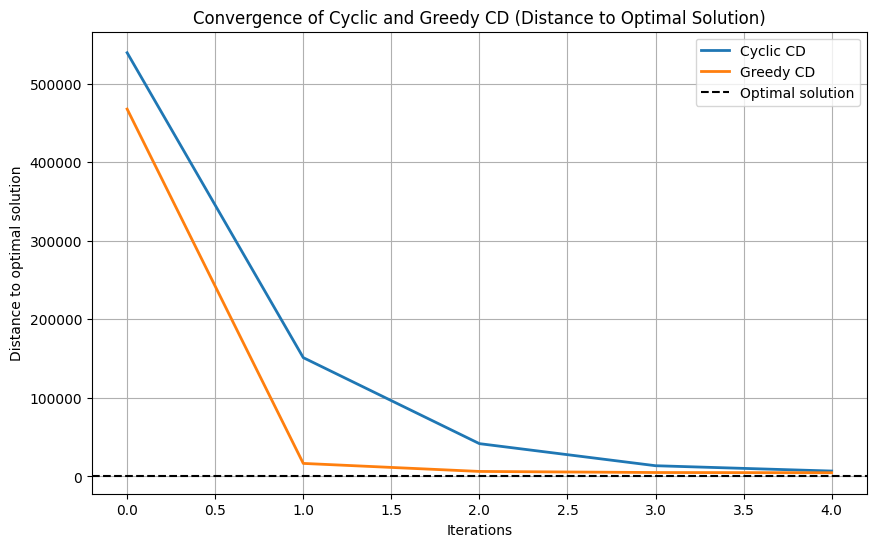

In [11]:
# Résolution exacte via linalg.lstsq
w_star, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

# Nombre d'itérations
n_iter = 500

# Exécuter les descentes de coordonnées
w_cyclic, objs_cyclic = cyclic_cd(A, b, n_iter)
w_greedy, objs_greedy = greedy_cd(A, b, n_iter)

# Calculer l'écart à la solution optimale (norme L2)
errors_cyclic = [np.linalg.norm(w - w_star) for w in objs_cyclic]
errors_greedy = [np.linalg.norm(w - w_star) for w in objs_greedy]

# Tracé des erreurs en fonction des itérations
plt.figure(figsize=(10, 6))
plt.plot(range(len(errors_cyclic)), errors_cyclic, label="Cyclic CD", linewidth=2)
plt.plot(range(len(errors_greedy)), errors_greedy, label="Greedy CD", linewidth=2)

# Ajouter la courbe pour la solution optimale
plt.axhline(y=0, color='black', linestyle='--', label="Optimal solution")

plt.xlabel("Iterations")
plt.ylabel("Distance to optimal solution")
plt.title("Convergence of Cyclic and Greedy CD (Distance to Optimal Solution)")
plt.legend()
plt.grid(True)
plt.show()

Nous avons choisi de représenter la norme de l'écart entre $w$ et $w_{*}$ en fonction du nombre d'itérations. L'objectif est donc d'arriver à $0$. Les deux méthodes montrent de bonnes performances en convergeant très rapidement vers la solution optimale. Cependant, la méthode Greedy CD converge encore plus vite que la Cyclic CD. 

La méthode Greedy CD est plus rapide mais plus coûteuse en calcul par itération. Pour un problème dense, cette méthode devient impraticable au-delà de quelques milliers de caractéristiques. Par conséquent, utiliser la méthode Greedy CD pour la régression logistique L2 ne serait pas optimale car la sélection de la coordonnée la plus impactante (gradient maximal) à chaque itération est coûteuse, surtout avec de nombreuses caractéristiques. Cela ralentirait considérablement les itérations.

De même, utiliser la méthode Greedy CD pour OLS avec 100000 caractéristiques serait impossible, le coût de calcul des gradients pour toutes les coordonnées à chaque itération deviendrait trop important.


## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that:
    $$
    \lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0
    $$
</div>
$$
\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0
$$
    
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p) $)

To obtain the minimum of the function, we must have $\hat{w}$ so that $\partial \mathcal{L}(\hat{w}) = 0$.

We found that $\partial \mathcal{L}(w) = -\sum_i y_ix_i\frac{1}{1 + \exp^{y_iw^Tx_i}} + \lambda \partial \Vert \cdot \Vert_1 (w)$

If $w = 0$, 

$$
\frac{1}{2}X^Ty = \lambda \partial \Vert \cdot \Vert_1 (0)
$$
$$
\lambda \geq \lambda_max
$$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

*answer here*

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [12]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros(n_iter)
    
    # TODO
    lips_const = np.linalg.norm(X, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -np.sum(y * X[:, j] * (1 - sigmoid(y * Xw)))
            w[j] = soft_thresh(grad_j / lips_const[j], lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += X[:, j] * (w[j] - old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [13]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia", version=1)

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [15]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [16]:
# 1. Proximal Gradient Descent (ISTA)
def ista(X, y, lambd, n_iter, learning_rate=0.1):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    all_objs = []
    
    for t in range(n_iter):
        gradient = -X.T.dot(y * (1 / (1 + np.exp(-y * X.dot(w))))) + lambd * np.sign(w)
        w -= learning_rate * gradient
        
        # Calcul de l'objectif
        obj = np.log(1 + np.exp(-y * X.dot(w))).sum() + lambd * norm(w, 1)
        all_objs.append(obj)
    
    return w, all_objs

# 2. Coordinate Descent (prox CD)
def prox_cd(X, y, lambd, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    all_objs = []
    
    # Constante de Lipschitz
    lips_const = np.linalg.norm(X, axis=0) ** 2
    
    for t in range(n_iter):
        for j in range(n_features):
            gradient_j = -np.sum(y * X[:, j] * (1 / (1 + np.exp(-y * X.dot(w)))))
            w[j] = soft_thresh(gradient_j / lips_const[j], lambd / lips_const[j])
        
        # Calcul de l'objectif
        obj = np.log(1 + np.exp(-y * X.dot(w))).sum() + lambd * norm(w, 1)
        all_objs.append(obj)
    
    return w, all_objs

# Nombre d'itérations
n_iter = 1000

# Exécution des deux méthodes
w_ista, objs_ista = ista(X, y, lambd, n_iter, learning_rate=0.1)
w_cd, objs_cd = prox_cd(X, y, lambd, n_iter)

# Plot des courbes de convergence
plt.figure(figsize=(12, 6))
plt.plot(range(n_iter), objs_ista, label='ISTA', color='blue')
plt.plot(range(n_iter), objs_cd, label='Prox CD', color='red')
plt.xlabel('Epochs')
plt.ylabel('Objective Value')
plt.title('Convergence of ISTA and Prox CD on the Leukemia Dataset')
plt.legend()
plt.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_43920\363454379.py:12: RuntimeWarning: overflow encountered in exp
  obj = np.log(1 + np.exp(-y * X.dot(w))).sum() + lambd * norm(w, 1)
C:\Users\simon\AppData\Local\Temp\ipykernel_43920\363454379.py:8: RuntimeWarning: overflow encountered in exp
  gradient = -X.T.dot(y * (1 / (1 + np.exp(-y * X.dot(w))))) + lambd * np.sign(w)


KeyboardInterrupt: 